In [1]:
import scanpy as sc
import anndata as ann
import scipy as sci
import pandas as pd
import os
import numpy as np
import louvain
import episcanpy.api as epi

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [2]:
%config InlineBackend.figure_format='retina'

# Loading the Data

In [3]:
SCATAC_DIR = '../data/scATAC/geneactivity/'

In [4]:
%%time
scatac = sc.read_10x_mtx(SCATAC_DIR, var_names='gene_ids', cache=True)

var = pd.read_csv(SCATAC_DIR + 'var.csv')
scatac.var = var

obs = pd.read_csv(SCATAC_DIR + 'obs.csv')
scatac.obs = obs

AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 


CPU times: user 15min 23s, sys: 4min 14s, total: 19min 38s
Wall time: 29min 13s


In [5]:
scatac

AnnData object with n_obs × n_vars = 70461 × 23899 
    obs: 'Unnamed: 0', 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'ProjectUMAP1', 'ProjectUMAP2', 'ProjectClassification'
    var: 'Unnamed: 0', 'gene_name', 'gene_id', 'exonLength'

In [6]:
scatac.obs.head()

,Unnamed: 0,FRIP,TotalReads,Group,Barcode,initialClusters,UMAP1,UMAP2,Clusters,ProjectUMAP1,ProjectUMAP2,ProjectClassification
0,BMM_R1_19,0.556943,67260,BMMC_D5T1,TAGGAGGGTGCACTTA-1,Cluster1,9.028878,-3.070899,Cluster1,-7.257169,-3.767484,07_GMP
1,BMM_R1_21,0.541798,17154,BMMC_D5T1,CCTAAAGTCCGCCTAT-1,Cluster2,0.151454,13.363869,Cluster2,9.737446,-2.393460,22_CD4.M
2,BMM_R1_24,0.551778,38974,BMMC_D5T1,CCTAAAGAGAAATACC-1,Cluster3,-3.914717,-6.629660,Cluster3,1.359905,12.922869,02_Early.Eryth
3,BMM_R1_25,0.590287,38898,BMMC_D5T1,TAAACCGCACATTCTT-1,Cluster4,-2.434527,12.142631,Cluster4,11.522385,1.818643,24_CD8.CM
4,BMM_R1_26,0.626936,36546,BMMC_D5T1,TTGCCCACATTCGTCC-1,Cluster4,-1.765110,12.288043,Cluster4,10.663303,0.689267,24_CD8.CM


In [7]:
scatac.var.head()

,Unnamed: 0,gene_name,gene_id,exonLength
0,7SK,7SK,ENSG00000249352,1449
1,A1BG,A1BG,ENSG00000121410,4006
2,A1BG-AS1,A1BG-AS1,ENSG00000268895,2793
3,A2M,A2M,ENSG00000175899,6384
4,A2M-AS1,A2M-AS1,ENSG00000245105,2187


# Data Cleaning

In [8]:
scatac.obs.set_index('Unnamed: 0', inplace=True)

In [9]:
scatac.var.set_index('Unnamed: 0', inplace=True)

In [10]:
scatac.obs.rename(columns={'ProjectClassification': 'cell_type'}, inplace=True)

In [11]:
scatac.obsm['X_umap'] = scatac.obs[['ProjectUMAP1', 'ProjectUMAP2']].to_numpy()
scatac.obs.drop(['ProjectUMAP1', 'ProjectUMAP2'], axis=1, inplace=True)

In [12]:
scatac.obs['condition'] = scatac.obs['cell_type'].map(lambda a: 'stimulated' if a.endswith('Like') else 'control')

In [13]:
scatac.obs.head()

,FRIP,TotalReads,Group,Barcode,initialClusters,UMAP1,UMAP2,Clusters,cell_type,condition
Unnamed: 0,,,,,,,,,,
BMM_R1_19,0.556943,67260,BMMC_D5T1,TAGGAGGGTGCACTTA-1,Cluster1,9.028878,-3.070899,Cluster1,07_GMP,control
BMM_R1_21,0.541798,17154,BMMC_D5T1,CCTAAAGTCCGCCTAT-1,Cluster2,0.151454,13.363869,Cluster2,22_CD4.M,control
BMM_R1_24,0.551778,38974,BMMC_D5T1,CCTAAAGAGAAATACC-1,Cluster3,-3.914717,-6.629660,Cluster3,02_Early.Eryth,control
BMM_R1_25,0.590287,38898,BMMC_D5T1,TAAACCGCACATTCTT-1,Cluster4,-2.434527,12.142631,Cluster4,24_CD8.CM,control
BMM_R1_26,0.626936,36546,BMMC_D5T1,TTGCCCACATTCGTCC-1,Cluster4,-1.765110,12.288043,Cluster4,24_CD8.CM,control


In [14]:
scatac.var.head()

,gene_name,gene_id,exonLength
Unnamed: 0,,,
7SK,7SK,ENSG00000249352,1449
A1BG,A1BG,ENSG00000121410,4006
A1BG-AS1,A1BG-AS1,ENSG00000268895,2793
A2M,A2M,ENSG00000175899,6384
A2M-AS1,A2M-AS1,ENSG00000245105,2187


Save the raw data:

In [15]:
%time scatac.write_h5ad(SCATAC_DIR + 'gene-activities-raw.h5ad')

... storing 'Group' as categorical
... storing 'Barcode' as categorical
... storing 'initialClusters' as categorical
... storing 'Clusters' as categorical
... storing 'cell_type' as categorical
... storing 'condition' as categorical


CPU times: user 2.48 s, sys: 2.11 s, total: 4.59 s
Wall time: 5.86 s


# Quality Control

Data is already quality controlled by the authors. Here we just plot to show this fact.

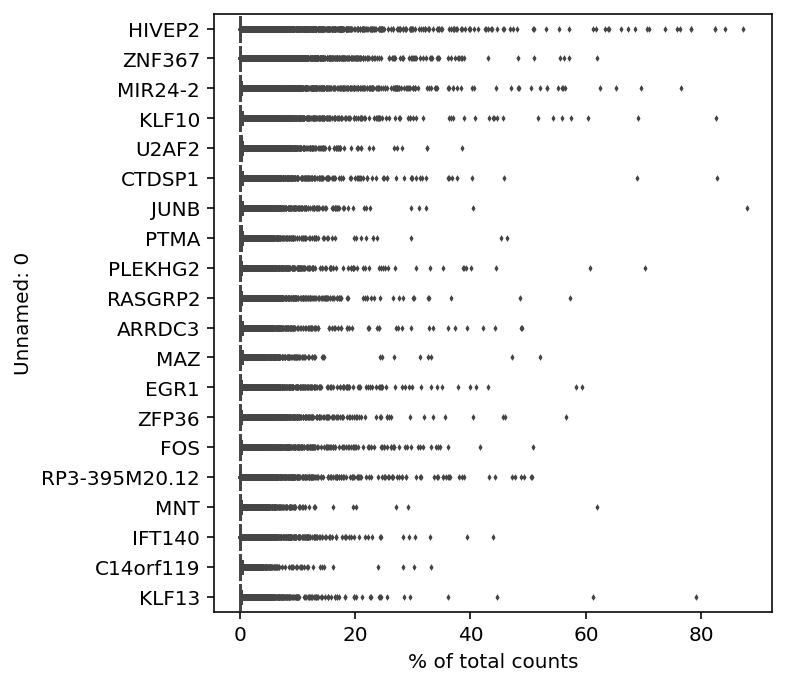

In [20]:
sc.pl.highest_expr_genes(scatac, n_top=20)

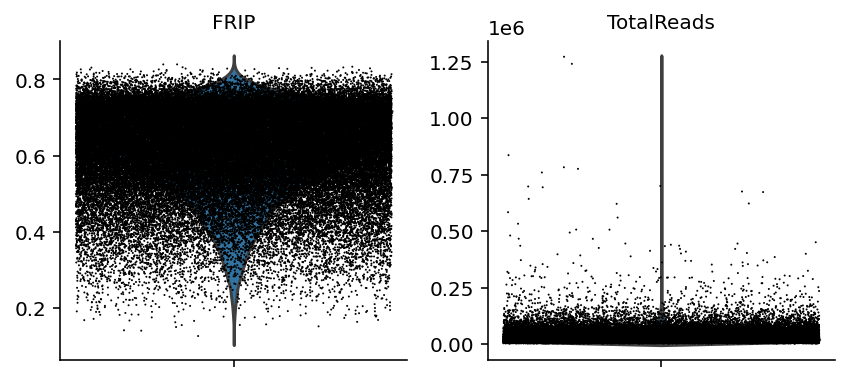

In [22]:
sc.pl.violin(scatac, ['FRIP', 'TotalReads'], jitter=0.4, multi_panel=True)

# Normalization

In [23]:
sc.pp.normalize_total(scatac, target_sum=1e4)
sc.pp.log1p(scatac)

In [25]:
scatac

AnnData object with n_obs × n_vars = 70461 × 23899 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition'
    var: 'gene_name', 'gene_id', 'exonLength'
    obsm: 'X_umap'

# Filtering Highly Variable Genes

In [26]:
sc.pp.highly_variable_genes(scatac, n_top_genes=3000)

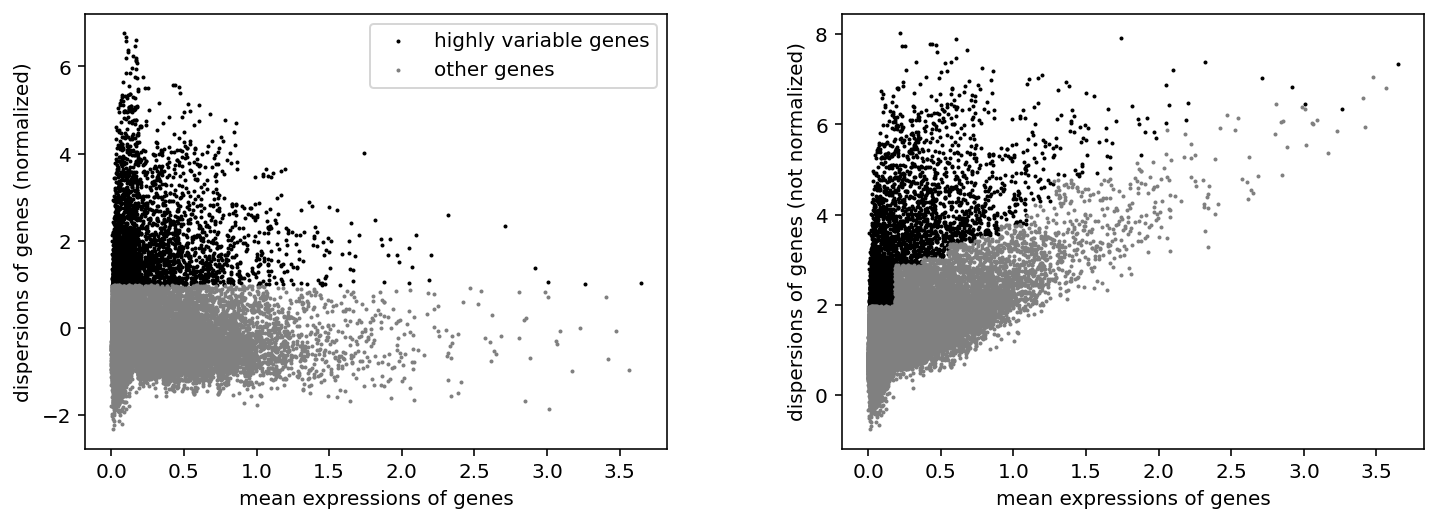

In [27]:
sc.pl.highly_variable_genes(scatac)

In [28]:
scatac = scatac[:, scatac.var.highly_variable]
scatac

View of AnnData object with n_obs × n_vars = 70461 × 3000 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition'
    var: 'gene_name', 'gene_id', 'exonLength', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_umap'

# Visualization

## UMAP using coordinates provided by the authors

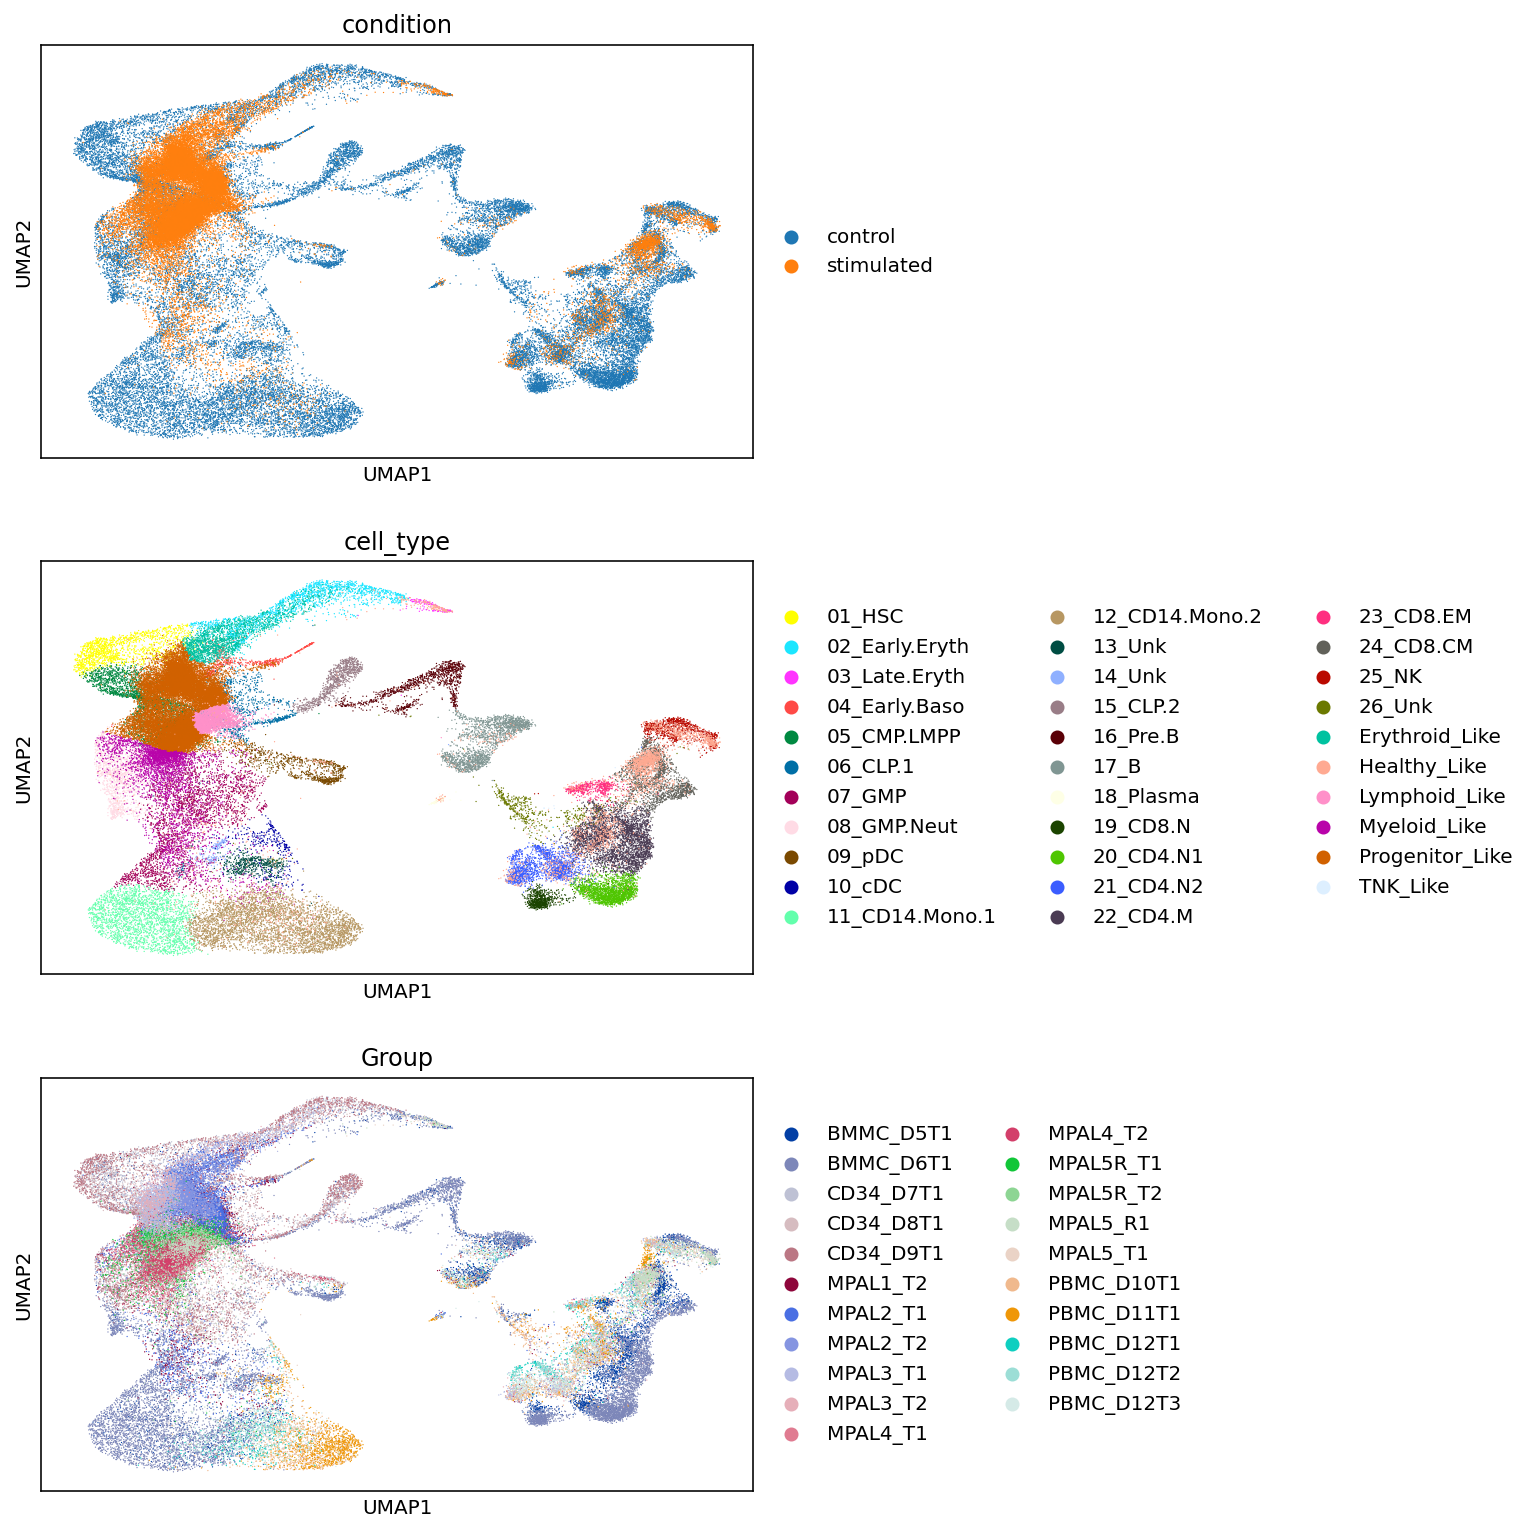

In [29]:
sc.pl.umap(scatac, color=['condition', 'cell_type', 'Group'], ncols=1)

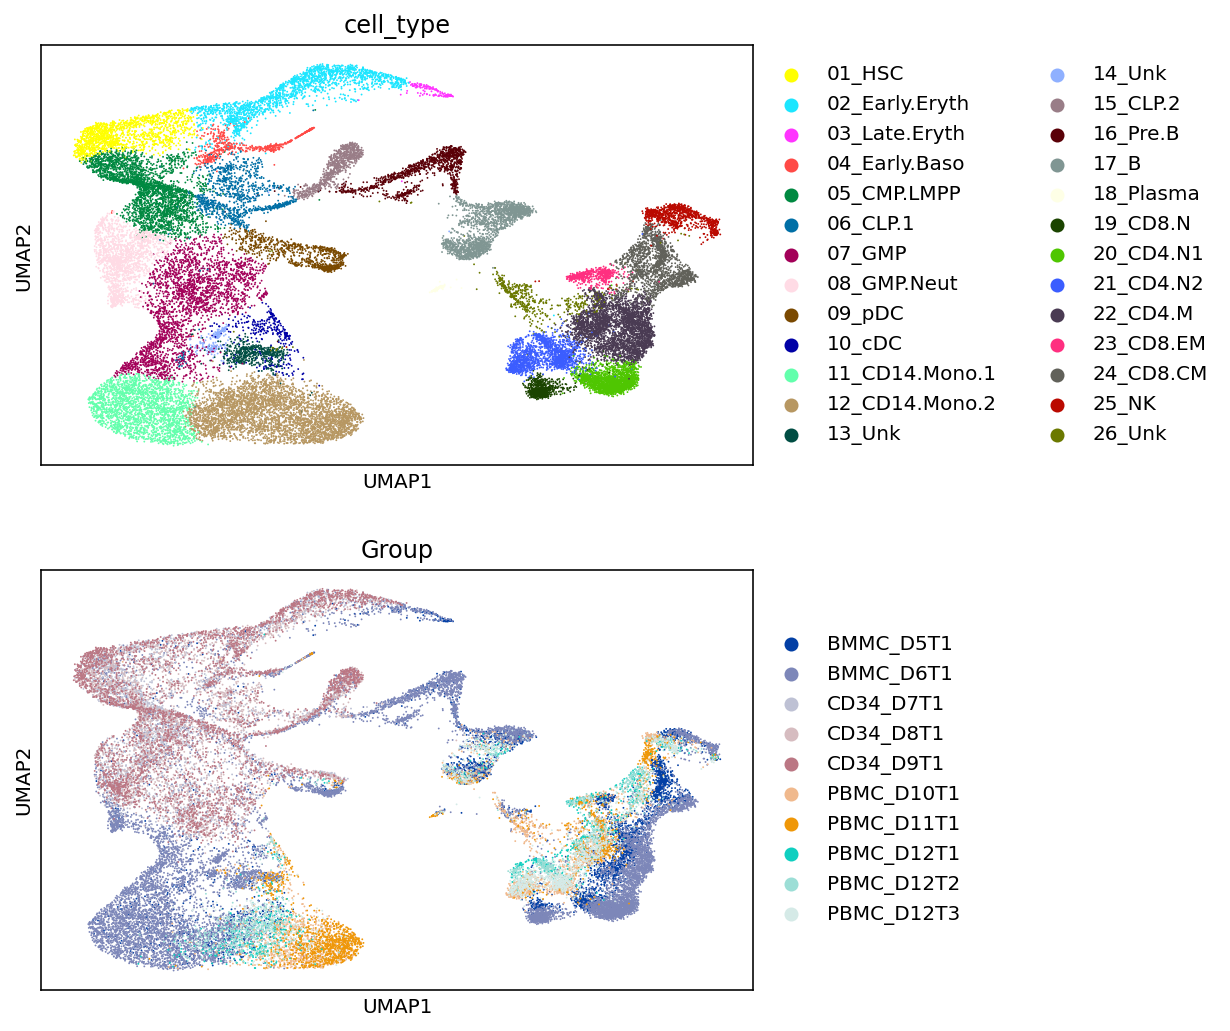

In [30]:
sc.pl.umap(scatac[scatac.obs['condition'] == 'control'], color=['cell_type', 'Group'], ncols=1)

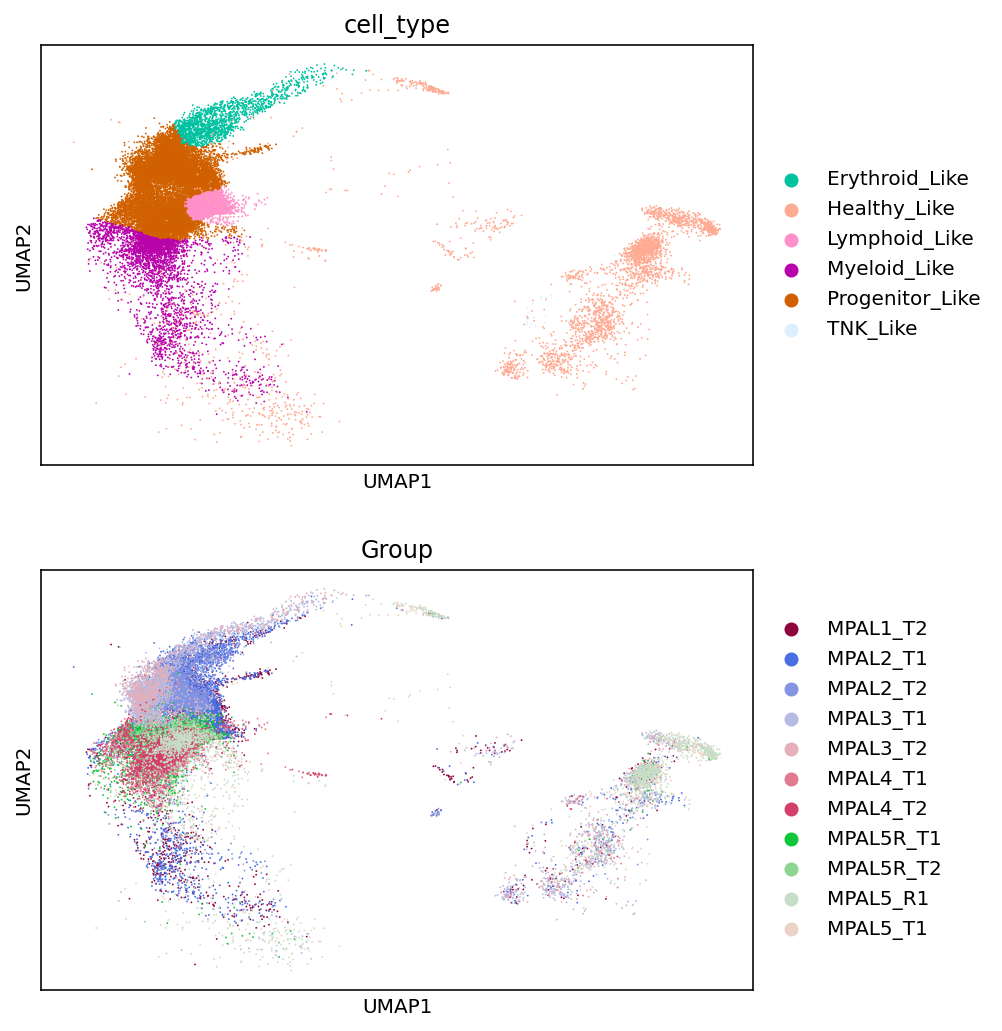

In [31]:
sc.pl.umap(scatac[scatac.obs['condition'] == 'stimulated'], color=['cell_type', 'Group'], ncols=1)

# Save the result

In [32]:
%time scatac.write_h5ad(SCATAC_DIR + 'gene-activities.h5ad')

CPU times: user 512 ms, sys: 396 ms, total: 908 ms
Wall time: 1 s
